In [38]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats as qs
import mplfinance as mpf
import pyarrow as pa
import pyarrow.parquet as pq

In [39]:
import sys
sys.path.append('/Users/Jason/work/source/03_ThorpAI')

In [3]:
from btc_model.core.util.log_util import Logger
from btc_model.core.update_data.okx_downloader import OKxDownloader

from btc_model.setting.setting import get_settings
from btc_model.core.common.const import PROJECT_NAME, Interval
from btc_model.core.util.file_util import FileUtil
from btc_model.core.common.const import (Exchange,
                                         Interval,
                                         InstrumentType,
                                         Product,
                                         EntityType,
                                         ProviderType
                                         )

from btc_model.core.data_loader.crypto_data_loader import CryptoDataLoader

In [35]:
# 读入日线行情
data_dir = FileUtil.get_project_dir(project_name=PROJECT_NAME, sub_dir='data')

data_loader = CryptoDataLoader(data_dir)

Logger.info('loading indicators of exchange okx')
df_indicator = data_loader.load_indicator_data(Exchange.OKX, Interval.DAILY, ProviderType.OKX)
df_indicator = df_indicator[df_indicator['symbol_id'] == 'BTC-USDT']
df_indicator['date'] = pd.to_datetime(df_indicator['datetime']).dt.date
df_indicator = df_indicator[[x for x in df_indicator.columns if x not in ['symbol_id', 'datetime','insert_timestamp',
       'modify_timestamp', 's2f_14_value']]]
df_indicator.set_index('date', inplace=True)


# df_indicator.to_csv('output/indicator.csv', index=False)

df_other_indicator = pd.DataFrame()
for provider_type in [ProviderType.ALTERNATIVE, ProviderType.BITCOIN_DATA]:
    Logger.info(f'loading indicators of data provider {provider_type.value.lower()}')
    data = data_loader.load_indicator_data(Exchange.NONE, Interval.DAILY, provider_type=provider_type)
    data['date'] = pd.to_datetime(data['date']).dt.date
    data.set_index('date', inplace=True)
    df_other_indicator = pd.concat([df_other_indicator, data], axis=1, ignore_index=False, join='outer')

# 排序索引，确保按日期对齐
df_other_indicator.sort_index(inplace=True)

df_final = pd.concat([df_indicator, df_other_indicator], axis=1, ignore_index=False).sort_index().dropna()

INFO   : 2025-02-10 21:26:43,469 >>> loading indicators of exchange okx
INFO   : 2025-02-10 21:26:43,484 >>> loading indicators of data provider alternative
INFO   : 2025-02-10 21:26:43,490 >>> loading indicators of data provider bitcoin_data


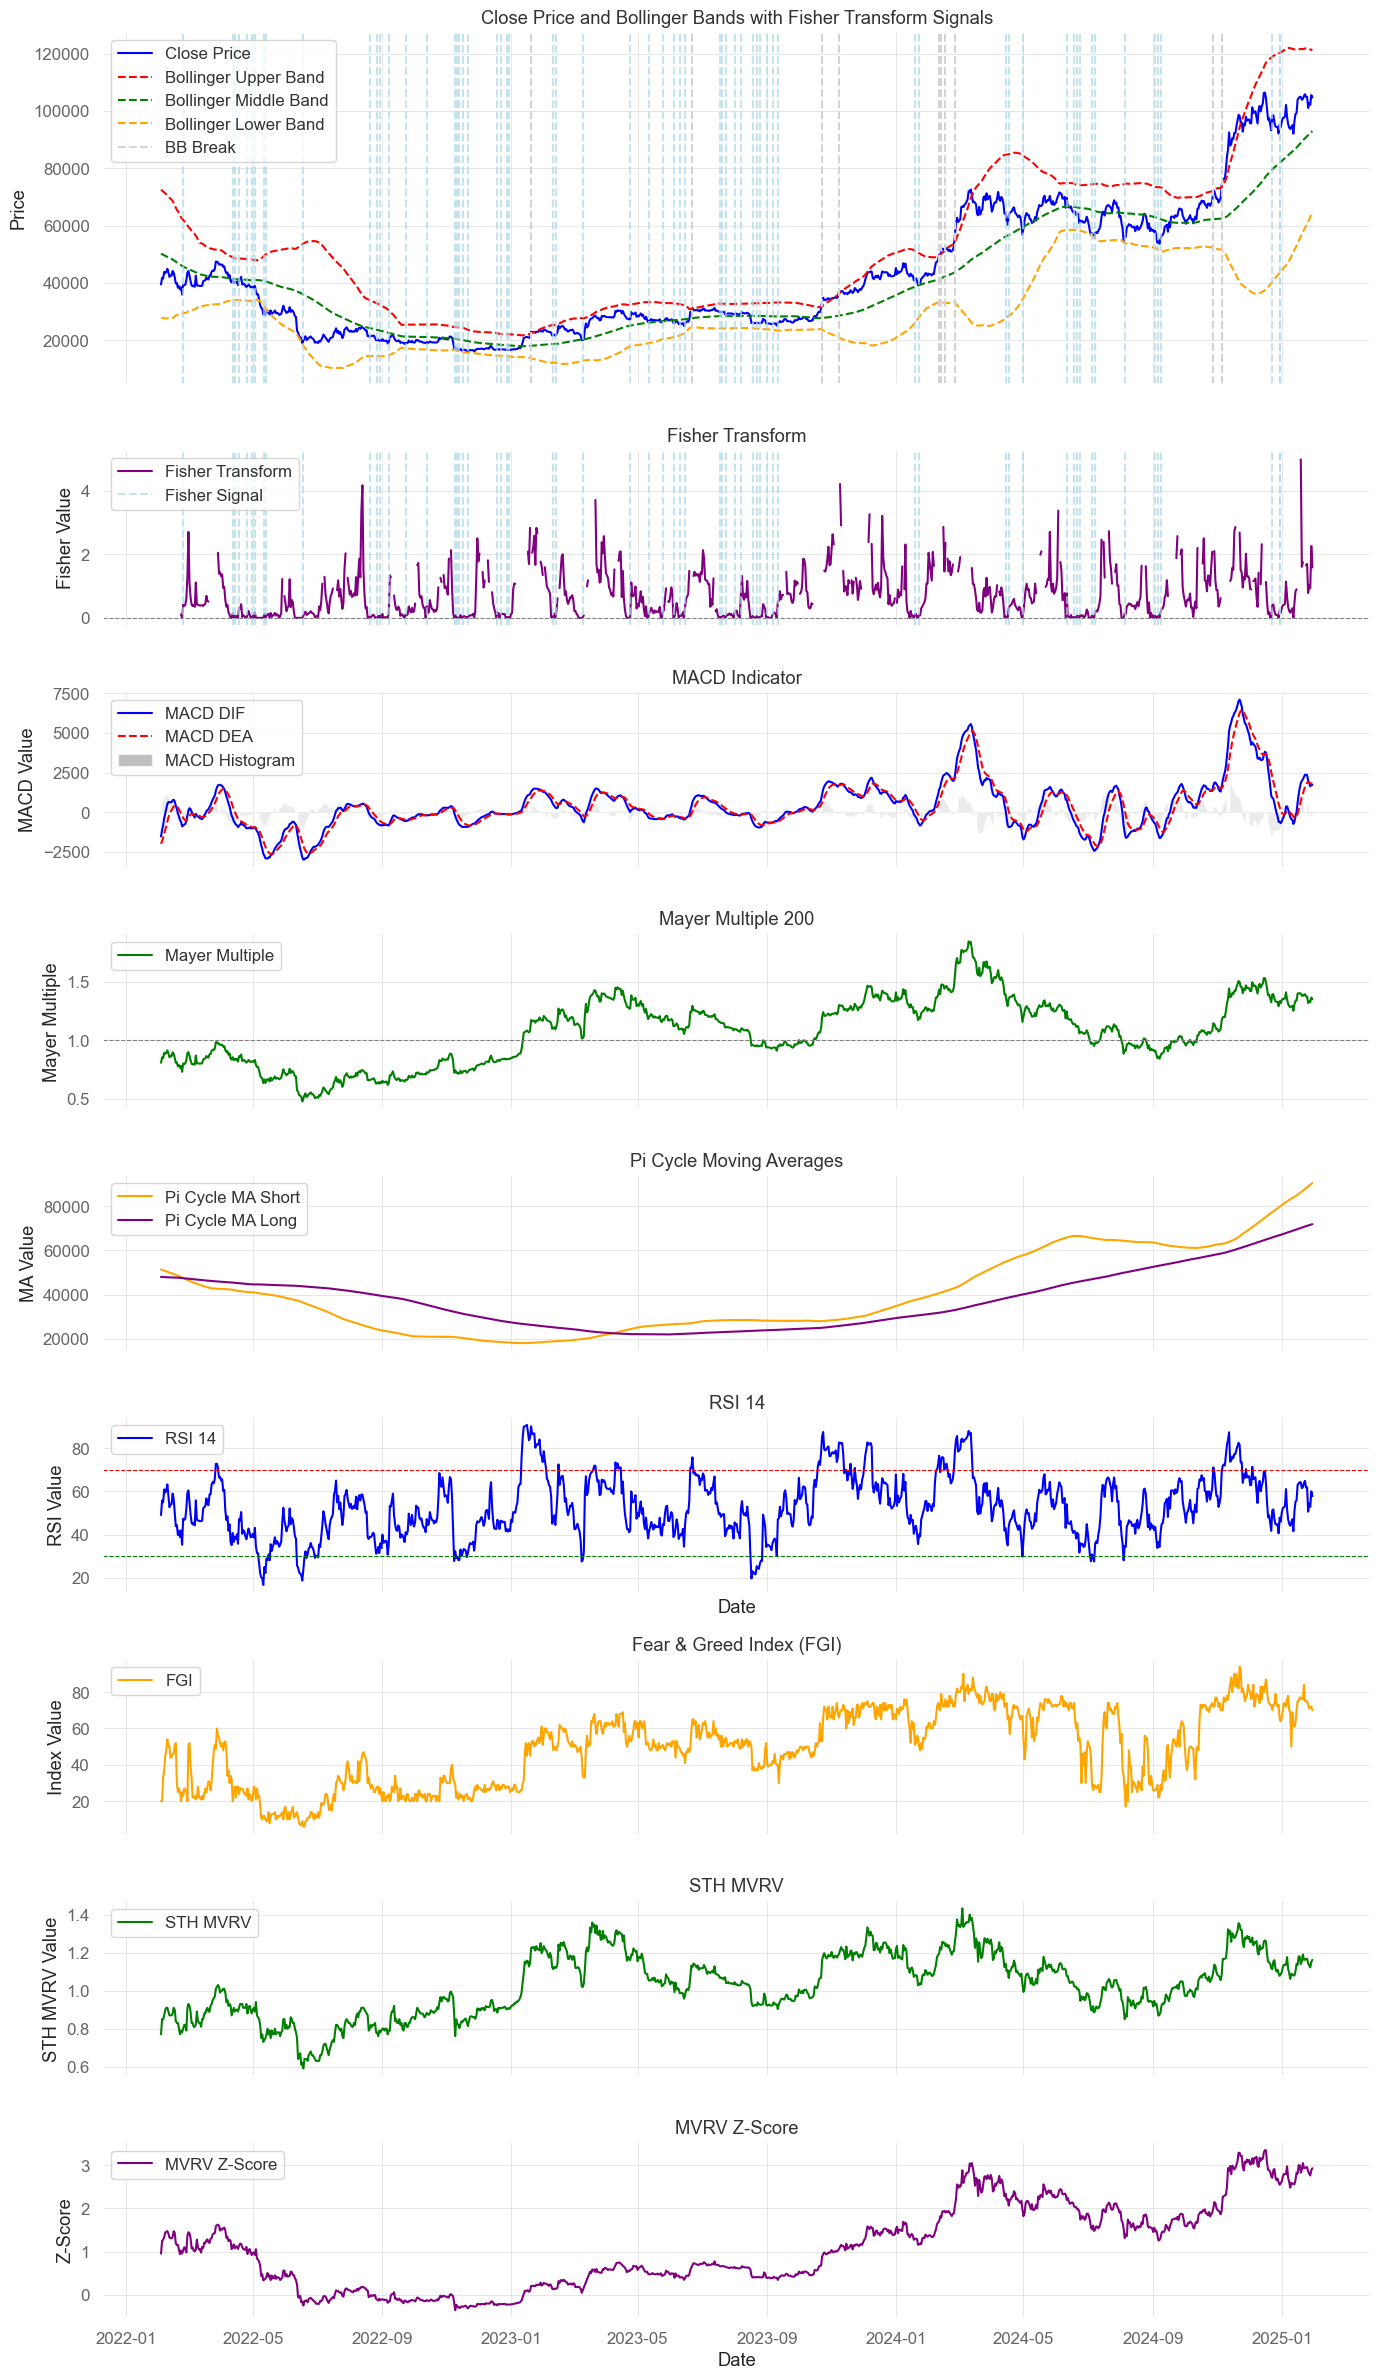

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = df_final.copy() 

# --- 计算费舍尔变换 ---
def fisher_transform(price, period=10):
    """计算费舍尔变换"""
    price_range = price.rolling(window=period).max() - price.rolling(window=period).min()
    relative_price = (price - price.rolling(window=period).min()) / price_range
    relative_price = np.clip(relative_price, 0, 1) # 确保在 0 和 1 之间
    fisher = 0.5 * np.log((1 + relative_price) / (1 - relative_price))
    return fisher

df['fisher'] = fisher_transform(df['close'], period=20) # 假设周期为20

# # --- 绘制图表 ---
# fig, axs = plt.subplots(6, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]}, sharex=True) # 创建包含6个子图的Figure
# --- 绘制图表 ---
fig, axs = plt.subplots(9, 1, figsize=(14, 24), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1, 1, 1]}, sharex=True) # 创建包含9个子图的Figure

# 第一个子图：Close Price 和 Bollinger Bands
ax1 = axs[0]

ax1.plot(df.index, df['close'], label='Close Price', color='blue')

# 绘制Bollinger Bands
ax1.plot(df.index, df['boll_100_2@5_upper'], label='Bollinger Upper Band', color='red', linestyle='--')
ax1.plot(df.index, df['boll_100_2@5_middle'], label='Bollinger Middle Band', color='green', linestyle='--')
ax1.plot(df.index, df['boll_100_2@5_lower'], label='Bollinger Lower Band', color='orange', linestyle='--')

# 添加垂直线标记布林带突破点
last_break_index_bb = None  # 记录最后一个布林带突破点的索引 (Bollinger Band Breakout)
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['boll_100_2@5_upper'].iloc[i] and df['close'].iloc[i-1] <= df['boll_100_2@5_upper'].iloc[i-1]:
        ax1.axvline(x=df.index[i], color='lightgray', linestyle='--')  # 添加垂直线
        last_break_index_bb = i  # 更新最后一个突破点的索引

# 只显示最后一次布林带突破的标签
if last_break_index_bb is not None:
    ax1.axvline(x=df.index[last_break_index_bb], color='lightgray', linestyle='--', label='BB Break') # BB Break for Bollinger Band Breakout

ax1.set_title('Close Price and Bollinger Bands with Fisher Transform Signals') # 修改主图标题
ax1.set_ylabel('Price')
ax1.legend(loc='upper left') # 图例放在左上角
ax1.grid(True) # 添加网格线

# 第二个子图：费舍尔变换
ax2 = axs[1]

ax2.plot(df.index, df['fisher'], label='Fisher Transform', color='purple')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8) # 零轴线

# 标记费舍尔变换的信号 (例如，Fisher 变换 crossing zero)
last_signal_index_fisher = None
for i in range(1, len(df)):
    if (df['fisher'].iloc[i] > 0 and df['fisher'].iloc[i-1] <= 0) or (df['fisher'].iloc[i] < 0 and df['fisher'].iloc[i-1] >= 0): # 费舍尔变换穿越零轴
        ax1.axvline(x=df.index[i], color='lightblue', linestyle='--', alpha=0.7) # 在主图上用浅蓝色垂直线标记Fisher信号
        ax2.axvline(x=df.index[i], color='lightblue', linestyle='--', alpha=0.7) # 在费舍尔变换子图上也标记
        last_signal_index_fisher = i

# 只显示最后一次费舍尔变换信号的标签
if last_signal_index_fisher is not None:
    ax1.axvline(x=df.index[last_signal_index_fisher], color='lightblue', linestyle='--', alpha=0.7, label='Fisher Signal') # Fisher Signal for Fisher Transform Signal
    ax2.axvline(x=df.index[last_signal_index_fisher], color='lightblue', linestyle='--', alpha=0.7, label='Fisher Signal') # 在费舍尔变换子图上也添加标签

ax2.set_title('Fisher Transform') 
ax2.set_ylabel('Fisher Value')
ax2.legend(loc='upper left')
ax2.grid(True) 

# 第三个子图：MACD 指标
ax3 = axs[2]

ax3.plot(df.index, df['macd_16_26_9_dif'], label='MACD DIF', color='blue')
ax3.plot(df.index, df['macd_16_26_9_dea'], label='MACD DEA', color='red', linestyle='--')
ax3.bar(df.index, df['macd_16_26_9_hist'], label='MACD Histogram', color='gray', alpha=0.5)

# 设置子图的标题和标签
ax3.set_title('MACD Indicator')
ax3.set_ylabel('MACD Value')
ax3.legend(loc='upper left')
ax3.grid(True)

# 第四个子图：Mayer Multiple
ax4 = axs[3]

ax4.plot(df.index, df['mayer_multiple_200_value'], label='Mayer Multiple', color='green')
ax4.axhline(1, color='gray', linestyle='--', linewidth=0.8) # Mayer Multiple 的基准线

ax4.set_title('Mayer Multiple 200')
ax4.set_ylabel('Mayer Multiple')
ax4.legend(loc='upper left') 
ax4.grid(True)

# 第五个子图：Pi Cycle MA (Short 和 Long)
ax5 = axs[4]

ax5.plot(df.index, df['pi_cycle_111_350__ma_short'], label='Pi Cycle MA Short', color='orange')
ax5.plot(df.index, df['pi_cycle_111_350_ma_long'], label='Pi Cycle MA Long', color='purple')

ax5.set_title('Pi Cycle Moving Averages')
ax5.set_ylabel('MA Value')
ax5.legend(loc='upper left')
ax5.grid(True) 

# 第六个子图：RSI
ax6 = axs[5]

ax6.plot(df.index, df['rsi_14_value'], label='RSI 14', color='blue')
ax6.axhline(70, color='red', linestyle='--', linewidth=0.8) # RSI 超买线
ax6.axhline(30, color='green', linestyle='--', linewidth=0.8) # RSI 超卖线

ax6.set_title('RSI 14')
ax6.set_xlabel('Date')
ax6.set_ylabel('RSI Value')
ax6.legend(loc='upper left') 
ax6.grid(True) 

# 第七个子图：恐惧贪婪指数 fgi_signal 和 fgi
ax7 = axs[6]
ax7.plot(df.index, df['fgi'], label='FGI', color='orange')
ax7.set_title('Fear & Greed Index (FGI)')
ax7.set_ylabel('Index Value')
ax7.legend(loc='upper left')
ax7.grid(True)

# 第八个子图：sth_mvrv
ax8 = axs[7]
ax8.plot(df.index, df['sth_mvrv'], label='STH MVRV', color='green')
ax8.set_title('STH MVRV')
ax8.set_ylabel('STH MVRV Value')
ax8.legend(loc='upper left')
ax8.grid(True)

# 第九个子图：mvrv_zscore
ax9 = axs[8]
ax9.plot(df.index, df['mvrv_zscore'], label='MVRV Z-Score', color='purple')
ax9.set_title('MVRV Z-Score')
ax9.set_xlabel('Date')
ax9.set_ylabel('Z-Score')
ax9.legend(loc='upper left')
ax9.grid(True)


# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

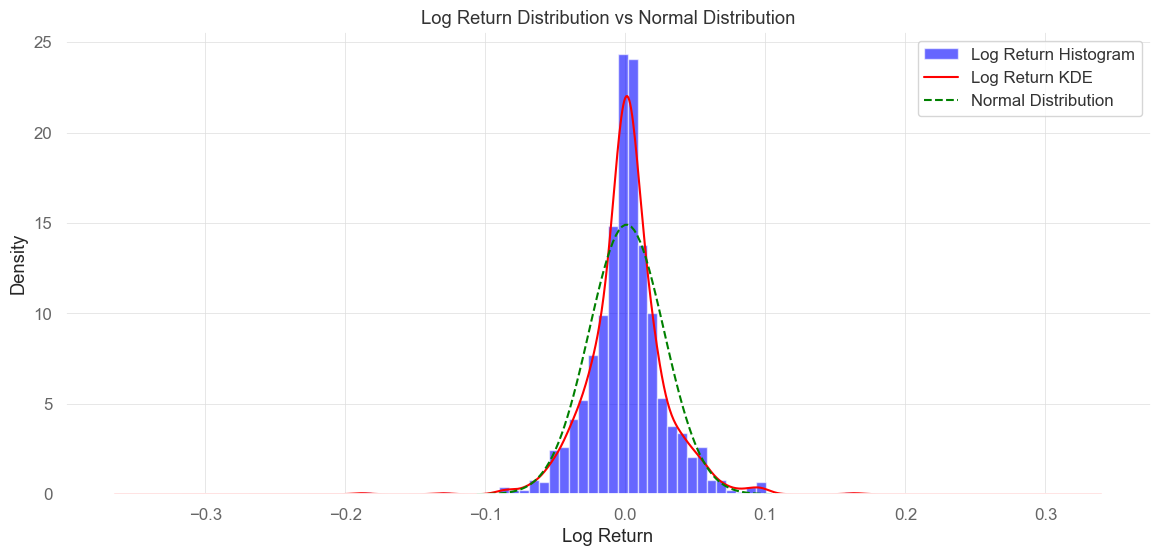

Shapiro-Wilk Test: Statistic=0.9462705452255731, p-value=1.7371445401584517e-19
Kolmogorov-Smirnov Test: Statistic=0.07978888302829679, p-value=1.7285645195274686e-06
Jarque-Bera Test: Statistic=1098.477977279084, p-value=2.9412909571193923e-239


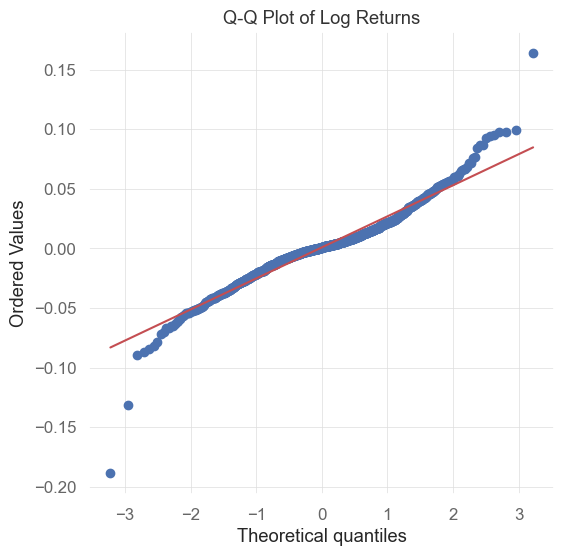

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

df = df_final.copy()

# --- 计算对数收益率 ---
df['log_return'] = np.log(df['close'] / df['close'].shift(1)) 
df = df.dropna() 

# --- 绘制收益率的直方图和核密度图 ---
plt.figure(figsize=(14, 6))

# 直方图
plt.hist(df['log_return'], bins=50, density=True, alpha=0.6, color='blue', label='Log Return Histogram')

# 核密度图
df['log_return'].plot(kind='kde', color='red', label='Log Return KDE')

# 添加正态分布参考曲线
mean = df['log_return'].mean()
std = df['log_return'].std()
x = np.linspace(mean - 4 * std, mean + 4 * std, 100)
plt.plot(x, stats.norm.pdf(x, mean, std), color='green', linestyle='--', label='Normal Distribution')

plt.title('Log Return Distribution vs Normal Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# --- 正态性检验 ---
# Shapiro-Wilk 检验
shapiro_test = stats.shapiro(df['log_return'])
print(f"Shapiro-Wilk Test: Statistic={shapiro_test[0]}, p-value={shapiro_test[1]}")

# Kolmogorov-Smirnov 检验
ks_test = stats.kstest(df['log_return'], 'norm', args=(mean, std))
print(f"Kolmogorov-Smirnov Test: Statistic={ks_test[0]}, p-value={ks_test[1]}")

# Jarque-Bera 检验
jb_test = stats.jarque_bera(df['log_return'])
print(f"Jarque-Bera Test: Statistic={jb_test[0]}, p-value={jb_test[1]}")

# --- 绘制 Q-Q 图 ---
plt.figure(figsize=(6, 6))
stats.probplot(df['log_return'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log Returns')
plt.grid(True)
plt.show()

2025-02-10 22:41:32.338 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.465 
  command:

    streamlit run /Users/Jason/work/source/03_ThorpAI/.venv/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-02-10 22:41:32.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.474 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-10 22:41:32.

DeltaGenerator()

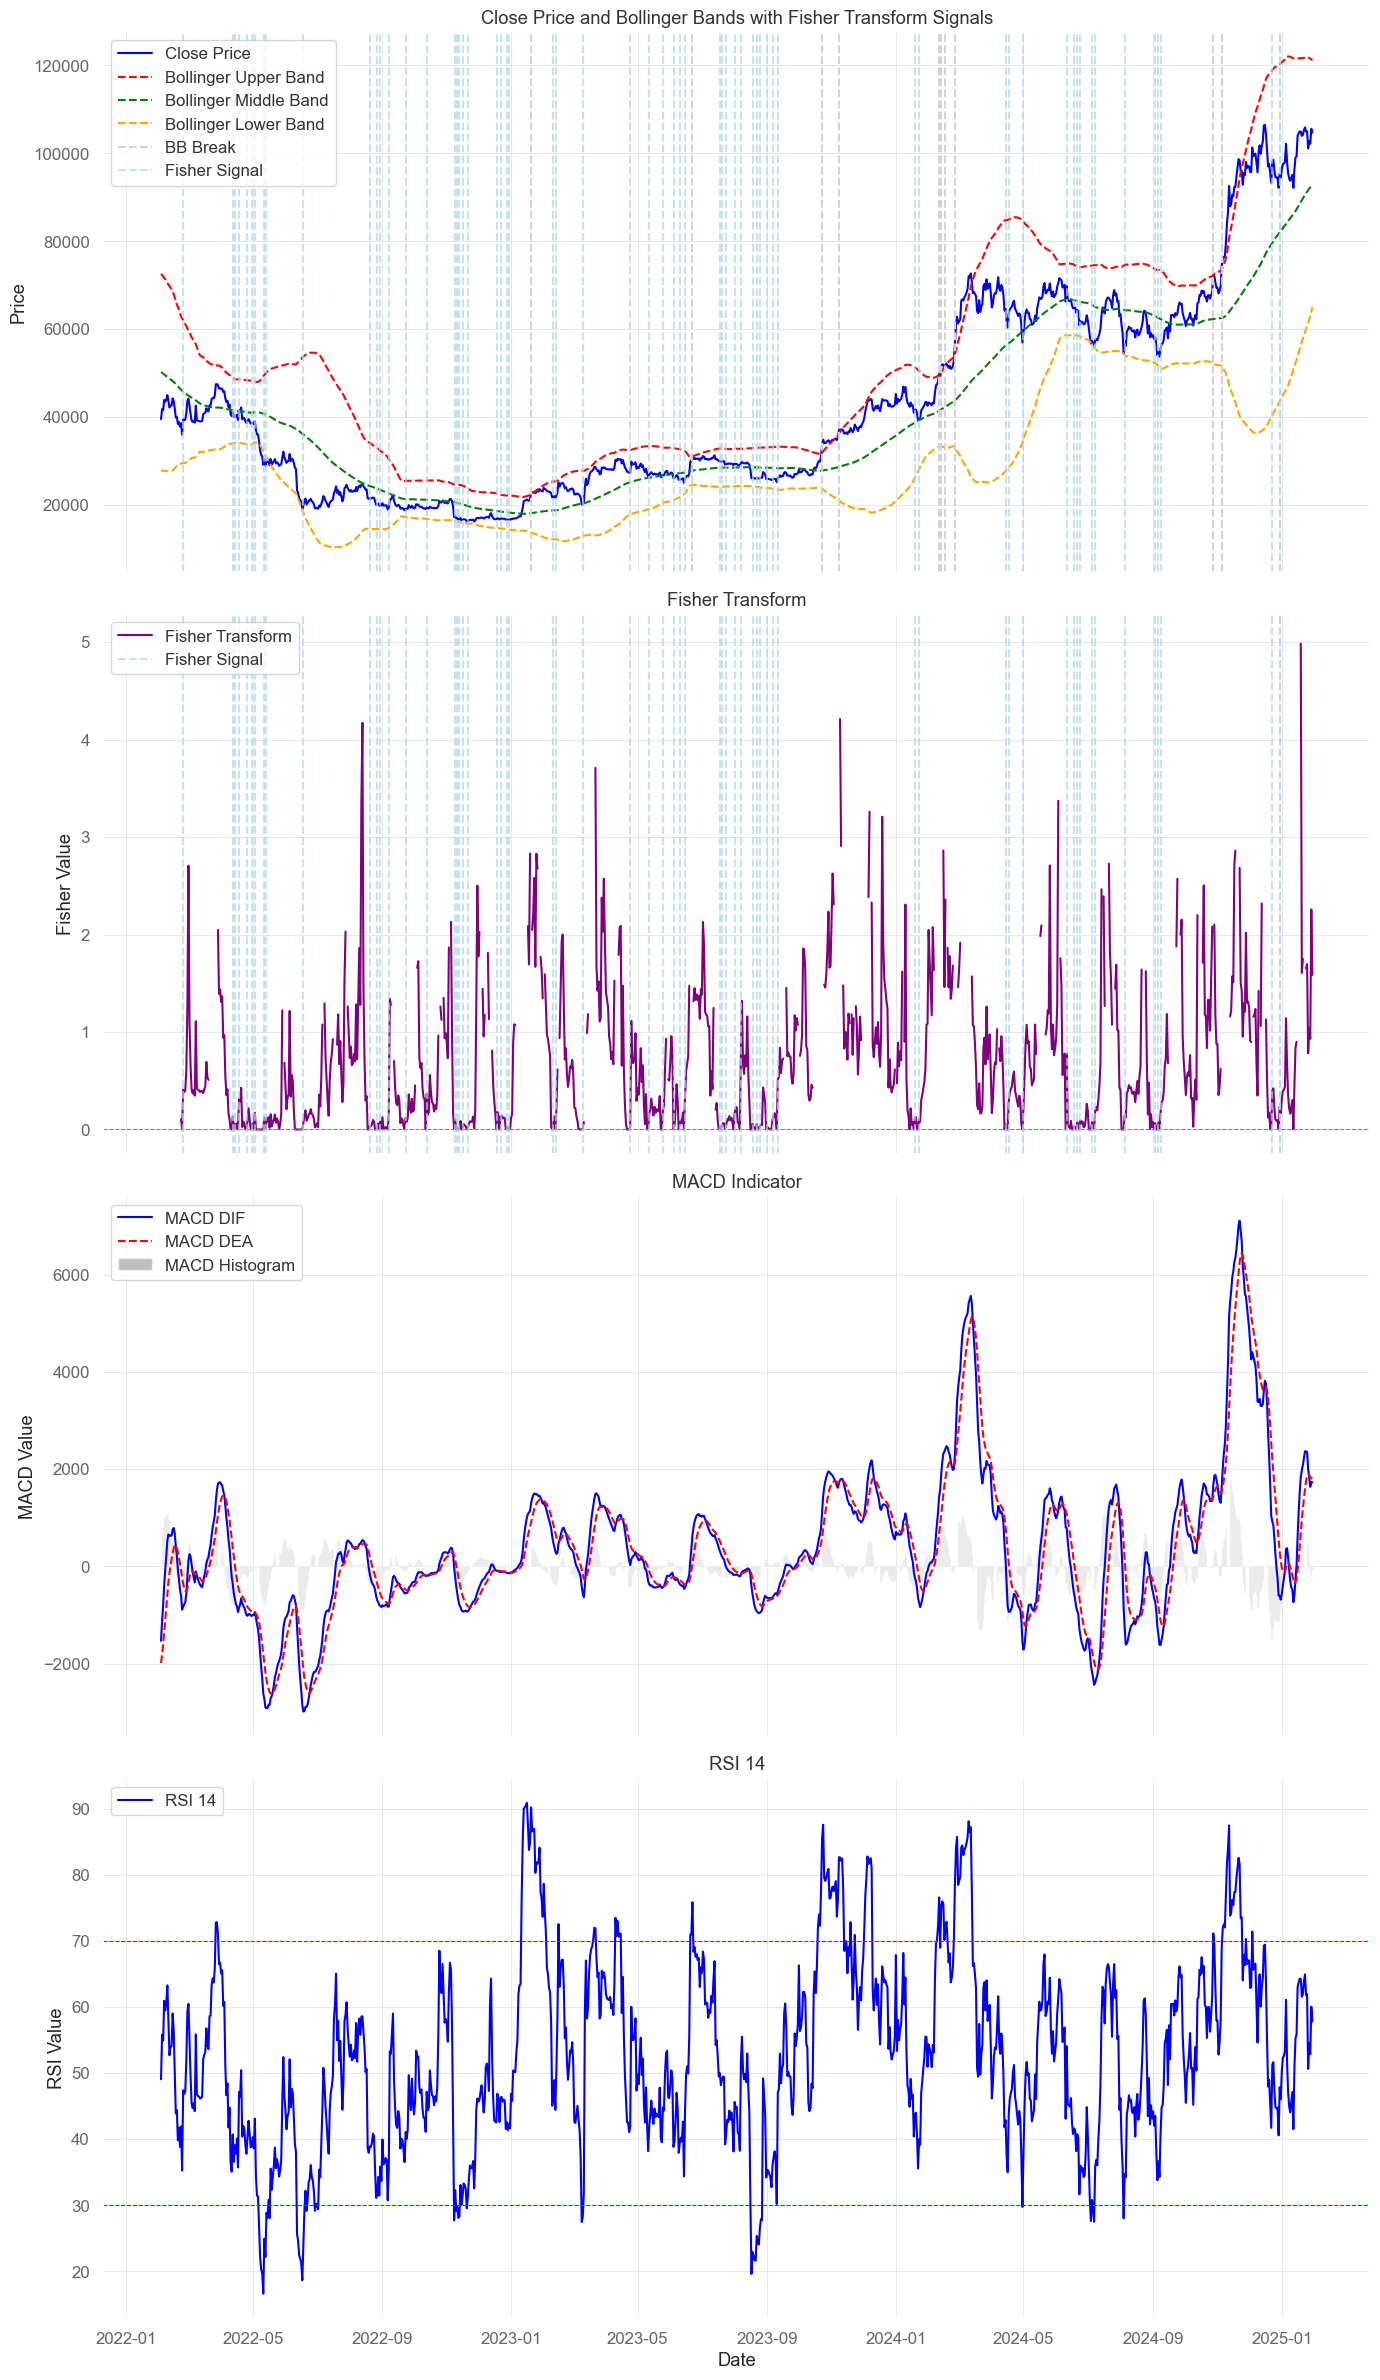

In [43]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 假设 df_final 已经定义，Streamlit 应用中需要加载数据
# 例如：df_final = pd.read_csv('your_data.csv')

# --- 费舍尔变换函数 (保持不变) ---
def fisher_transform(price, period=10):
    price_range = price.rolling(window=period).max() - price.rolling(window=period).min()
    relative_price = (price - price.rolling(window=period).min()) / price_range
    relative_price = np.clip(relative_price, 0, 1)
    fisher = 0.5 * np.log((1 + relative_price) / (1 - relative_price))
    return fisher

# 标题
st.title('技术指标交互图表')

# 子图选择
selected_plots = st.multiselect(
    '选择要显示的子图:',
    ['Close Price & Bollinger Bands', 'Fisher Transform', 'MACD', 'Mayer Multiple', 'Pi Cycle MA', 'RSI', 'Fear & Greed Index', 'STH MVRV', 'MVRV Z-Score'],
    default=['Close Price & Bollinger Bands', 'Fisher Transform', 'MACD', 'RSI'] # 默认选择
)

df = df_final.copy() # 复制数据，防止修改原始数据

# 计算 Fisher 变换 (确保在绘图前计算)
df['fisher'] = fisher_transform(df['close'], period=20)

# --- 创建子图 ---
num_plots = len(selected_plots)
fig, axs = plt.subplots(num_plots, 1, figsize=(14, 6 * num_plots), sharex=True) # 根据选择的图表数量动态调整高度
axs = [axs] if num_plots == 1 else axs # 当只有一个子图时，确保 axs 是列表

plot_index = 0 # 用于追踪当前绘制的子图索引

# --- 绘制 Close Price 和 Bollinger Bands ---
if 'Close Price & Bollinger Bands' in selected_plots:
    ax1 = axs[plot_index]

    ax1.plot(df.index, df['close'], label='Close Price', color='blue')
    ax1.plot(df.index, df['boll_100_2@5_upper'], label='Bollinger Upper Band', color='red', linestyle='--')
    ax1.plot(df.index, df['boll_100_2@5_middle'], label='Bollinger Middle Band', color='green', linestyle='--')
    ax1.plot(df.index, df['boll_100_2@5_lower'], label='Bollinger Lower Band', color='orange', linestyle='--')

    last_break_index_bb = None
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['boll_100_2@5_upper'].iloc[i] and df['close'].iloc[i-1] <= df['boll_100_2@5_upper'].iloc[i-1]:
            ax1.axvline(x=df.index[i], color='lightgray', linestyle='--')
            last_break_index_bb = i

    if last_break_index_bb is not None:
        ax1.axvline(x=df.index[last_break_index_bb], color='lightgray', linestyle='--', label='BB Break')

    # 叠加 Fisher Transform 信号
    last_signal_index_fisher = None
    for i in range(1, len(df)):
        if (df['fisher'].iloc[i] > 0 and df['fisher'].iloc[i-1] <= 0) or (df['fisher'].iloc[i] < 0 and df['fisher'].iloc[i-1] >= 0):
            ax1.axvline(x=df.index[i], color='lightblue', linestyle='--', alpha=0.7)
            last_signal_index_fisher = i

    if last_signal_index_fisher is not None:
        ax1.axvline(x=df.index[last_signal_index_fisher], color='lightblue', linestyle='--', alpha=0.7, label='Fisher Signal')

    ax1.set_title('Close Price and Bollinger Bands with Fisher Transform Signals')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    plot_index += 1

# --- 绘制 Fisher Transform ---
if 'Fisher Transform' in selected_plots:
    ax2 = axs[plot_index]

    ax2.plot(df.index, df['fisher'], label='Fisher Transform', color='purple')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    last_signal_index_fisher = None
    for i in range(1, len(df)):
        if (df['fisher'].iloc[i] > 0 and df['fisher'].iloc[i-1] <= 0) or (df['fisher'].iloc[i] < 0 and df['fisher'].iloc[i-1] >= 0):
             ax2.axvline(x=df.index[i], color='lightblue', linestyle='--', alpha=0.7)
             last_signal_index_fisher = i

    if last_signal_index_fisher is not None:
        ax2.axvline(x=df.index[last_signal_index_fisher], color='lightblue', linestyle='--', alpha=0.7, label='Fisher Signal')

    ax2.set_title('Fisher Transform')
    ax2.set_ylabel('Fisher Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    plot_index += 1

# --- 绘制 MACD 指标 ---
if 'MACD' in selected_plots:
    ax3 = axs[plot_index]

    ax3.plot(df.index, df['macd_16_26_9_dif'], label='MACD DIF', color='blue')
    ax3.plot(df.index, df['macd_16_26_9_dea'], label='MACD DEA', color='red', linestyle='--')
    ax3.bar(df.index, df['macd_16_26_9_hist'], label='MACD Histogram', color='gray', alpha=0.5)

    ax3.set_title('MACD Indicator')
    ax3.set_ylabel('MACD Value')
    ax3.legend(loc='upper left')
    ax3.grid(True)
    plot_index += 1

# --- 绘制 Mayer Multiple ---
if 'Mayer Multiple' in selected_plots:
    ax4 = axs[plot_index]

    ax4.plot(df.index, df['mayer_multiple_200_value'], label='Mayer Multiple', color='green')
    ax4.axhline(1, color='gray', linestyle='--', linewidth=0.8)

    ax4.set_title('Mayer Multiple 200')
    ax4.set_ylabel('Mayer Multiple')
    ax4.legend(loc='upper left')
    ax4.grid(True)
    plot_index += 1

# --- 绘制 Pi Cycle MA ---
if 'Pi Cycle MA' in selected_plots:
    ax5 = axs[plot_index]

    ax5.plot(df.index, df['pi_cycle_111_350__ma_short'], label='Pi Cycle MA Short', color='orange')
    ax5.plot(df.index, df['pi_cycle_111_350_ma_long'], label='Pi Cycle MA Long', color='purple')

    ax5.set_title('Pi Cycle Moving Averages')
    ax5.set_ylabel('MA Value')
    ax5.legend(loc='upper left')
    ax5.grid(True)
    plot_index += 1

# --- 绘制 RSI ---
if 'RSI' in selected_plots:
    ax6 = axs[plot_index]

    ax6.plot(df.index, df['rsi_14_value'], label='RSI 14', color='blue')
    ax6.axhline(70, color='red', linestyle='--', linewidth=0.8)
    ax6.axhline(30, color='green', linestyle='--', linewidth=0.8)

    ax6.set_title('RSI 14')
    ax6.set_xlabel('Date')
    ax6.set_ylabel('RSI Value')
    ax6.legend(loc='upper left')
    ax6.grid(True)
    plot_index += 1

# --- 绘制 Fear & Greed Index (FGI) ---
if 'Fear & Greed Index' in selected_plots:
    ax7 = axs[plot_index]
    ax7.plot(df.index, df['fgi'], label='FGI', color='orange')
    ax7.set_title('Fear & Greed Index (FGI)')
    ax7.set_ylabel('Index Value')
    ax7.legend(loc='upper left')
    ax7.grid(True)
    plot_index += 1

# --- 绘制 STH MVRV ---
if 'STH MVRV' in selected_plots:
    ax8 = axs[plot_index]
    ax8.plot(df.index, df['sth_mvrv'], label='STH MVRV', color='green')
    ax8.set_title('STH MVRV')
    ax8.set_ylabel('STH MVRV Value')
    ax8.legend(loc='upper left')
    ax8.grid(True)
    plot_index += 1

# --- 绘制 MVRV Z-Score ---
if 'MVRV Z-Score' in selected_plots:
    ax9 = axs[plot_index]
    ax9.plot(df.index, df['mvrv_zscore'], label='MVRV Z-Score', color='purple')
    ax9.set_title('MVRV Z-Score')
    ax9.set_xlabel('Date')
    ax9.set_ylabel('Z-Score')
    ax9.legend(loc='upper left')
    plot_index += 1

# 调整子图布局
plt.tight_layout()

# 在 Streamlit 中显示 Matplotlib 图表
st.pyplot(fig)